In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter as gf
import numpy as np
import importlib
import importlib
importlib.reload(plt)
import LATIS
plt.style.use('paper.mystyle')
#plt.style.use('tableau-colorblind10')

In [2]:
from scipy.ndimage import gaussian_filter as gf
import h5py
import numpy as np
import LATIS

def detected_progs_contours(lmap, flux_map, mlim=[13.5, np.inf], thresh=-2.0):
    """Find and count the detected progenitors more massive than mlim within each contour"""
    import LATIS.codes.minima as minima
    flux_map = gf(flux_map, sigma=4, mode='wrap')
    _ , lmap = minima.find_extrema_v3(mapconv=flux_map, thresh=thresh, linking_contour=-thresh)
    
    fcofm = h5py.File('cofm_progenitors.hdf5','r')
    all_clusters = h5py.File('clusters_TNG300-1.hdf5','r')
    # Select only massive progenitors
    Mass = np.log10(all_clusters['Mass'][:])+10
    indm = np.where((Mass > mlim[0])*(Mass < mlim[1]))[0]
    indm = np.isin(fcofm['cluster_ind'][:], indm, assume_unique=True)
    prog = np.zeros((205,205,205))
    x, y, z = fcofm['x'][:][indm].astype(int), fcofm['y'][:][indm].astype(int), fcofm['z'][:][indm].astype(int)
    # Count progenitors from 1 not 0
    prog[x,y,z] = fcofm['cluster_ind'][:][indm]+1
    
    detected_progs_num = np.array([])
    ind = np.unique(lmap)[1::]
    for j in ind :
        contour = np.zeros_like(lmap, dtype=int)
        contour[np.where(lmap==j)] = 1
        overlap_progs = np.unique(prog*contour).astype(int)[1::]
        # Return the prog counting to start from 0 (index of the cluster at z=0)
        detected_progs_num = np.append(detected_progs_num, overlap_progs.size)
        
    return detected_progs_num


def detected_progs_parents(lmap, peaks, mlim=[13.5, np.inf]):
    """Find and count the detected progenitors more massive than mlim within each parent countour
    The difference with the code above is in excluding the contours hosting peaks with significance between
    -2.0 ansd -2.35. """
    fcofm = h5py.File('cofm_progenitors.hdf5','r')
    all_clusters = h5py.File('clusters_TNG300-1.hdf5','r')
    # Select only massive progenitors
    Mass = np.log10(all_clusters['Mass'][:])+10
    indm = np.where((Mass > mlim[0])*(Mass < mlim[1]))[0]
    indm = np.isin(fcofm['cluster_ind'][:], indm, assume_unique=True)
    prog = np.zeros((205,205,205))
    x, y, z = fcofm['x'][:][indm].astype(int), fcofm['y'][:][indm].astype(int), fcofm['z'][:][indm].astype(int)
    # Count progenitors from 1 not 0
    prog[x,y,z] = fcofm['cluster_ind'][:][indm]+1
    
    detected_progs_num = np.array([])
    parents = np.unique(peaks['parentid'][:])
    for j in parents :
        SubregionIDs = np.where(peaks['parentid'][:] == j)[0] + 1
        contour = np.zeros_like(lmap, dtype=int)
        contour[np.isin(lmap, SubregionIDs)] = 1
        overlap_progs = np.unique(prog*contour).astype(int)[1::]
        # Return the prog counting to start from 0 (index of the cluster at z=0)
        detected_progs_num = np.append(detected_progs_num, overlap_progs.size)
        
    return detected_progs_num

def detected_progs_subregions(lmap, peaks, mlim=[13.5, np.inf]):
    """Find and count the detected progenitors more massive than mlim within each subregion"""
    fcofm = h5py.File('cofm_progenitors.hdf5','r')
    all_clusters = h5py.File('clusters_TNG300-1.hdf5','r')
    # Select only massive progenitors
    Mass = np.log10(all_clusters['Mass'][:])+10
    indm = np.where((Mass > mlim[0])*(Mass < mlim[1]))[0]
    indm = np.isin(fcofm['cluster_ind'][:], indm, assume_unique=True)
    prog = np.zeros((205,205,205))
    x, y, z = fcofm['x'][:][indm].astype(int), fcofm['y'][:][indm].astype(int), fcofm['z'][:][indm].astype(int)
    # Count progenitors from 1 not 0
    prog[x,y,z] = fcofm['cluster_ind'][:][indm]+1
    
    detected_progs_num = np.array([])
    for i in range(1,peaks['x'].size+1):
        contour = np.zeros((205,205,205), dtype=int)
        ind = np.where(lmap == i)
        contour[ind] = 1
        overlap_progs = np.unique(prog*contour).astype(int)[1::]
        # Return the prog counting to start from 0 (index of the cluster at z=0)
        detected_progs_num = np.append(detected_progs_num, overlap_progs.size)
        
    return detected_progs_num


In [11]:
%%time
nrange = np.arange(1,21)
detected_contours, detected_parents, detected_subregions = [], [], []
for n in nrange:
    print(n)
    detected_contours.append(detected_progs_contours(lmap=h5py.File('./thresh/n'+str(n)+'/labeled_map_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5','r')['map'][:],thresh=-2.0,flux_map = np.fromfile('./spectra/maps/map_TNG_z2.4_n'+str(n)+'.dat').reshape((205,205,205))))
    detected_subregions.append(detected_progs_subregions(lmap=h5py.File('./thresh/n'+str(n)+'/labeled_map_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5','r')['map'][:],peaks= h5py.File('./thresh/n'+str(n)+'/peaks_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5','r')))
    detected_parents.append(detected_progs_parents(lmap=h5py.File('./thresh/n'+str(n)+'/labeled_map_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5','r')['map'][:], peaks= h5py.File('./thresh/n'+str(n)+'/peaks_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5','r')))


20
Initially got 334 peaks, 
label started
Periodic BC. Init num of countours:  194
Final Num of countours:  178
CPU times: user 1min 46s, sys: 9.31 s, total: 1min 55s
Wall time: 1min 56s


In [12]:
def write_detected_progs():
    with h5py.File('./thresh/prog_counts_z2.4_sigma4.hdf5','w') as fw:
        for i, n in enumerate(np.arange(1,21)):
            fw[str(n)+'/contours'] = detected_contours[i]
            fw[str(n)+'/subregions'] = detected_subregions[i]
            fw[str(n)+'/parents'] = detected_parents[i]

Plot the mean counts :

In [5]:
def plot_prog_count_for_paper(num_mocks=20, savefig='islands_subregions_progs_count_noiseless.png', xmax=4, density=False):
    fig, ax = plt.subplots(1, 2, figsize=(15,10), gridspec_kw={'width_ratios': [5, 1]})

    mlim=[13.5,np.inf]
    
    f = h5py.File('./thresh/prog_counts_z2.4_sigma4.hdf5','r')
    colors = ['C0','C1','C2']
    dets = ['contours', 'parents', 'subregions']
    ls= ['solid', '-.', 'dashed']
    label=['Islands ',
           r'$\mathrm{Islands \ with \ (\delta_F /\sigma)_{peak} \leq \kappa \ = -2.35}$','Watersheds']
    
    def _plot_hist(det, label, ls, color):
        bins= np.arange( -0.5, 50.5, 1.)
        mbins = np.array([(bins[b]+bins[b+1])/2 for b in range(bins.size-1)])
        counts = np.zeros((num_mocks+1,mbins.size))
        for i,n in enumerate(np.arange(1,num_mocks+1)):
            counts_temp, _ = np.histogram(f[str(n)+'/'+str(det)], bins, density=False)
            counts[i] = counts_temp
        mean_counts = np.around(np.mean(counts, axis=0))
        std_counts = np.around(np.std(counts, axis=0))
        det_mean = np.repeat(mbins, mean_counts.astype(int))
        hist = ax[0].hist(det_mean, bins=bins, histtype='step', label=label,ls=ls, linewidth=9, density=density, color=color)
        ax[0].errorbar(mbins, mean_counts, yerr=std_counts, fmt='.', capsize=7, capthick=5, linewidth=3)

        det_mean[det_mean >= xmax] = xmax
        ax[1].hist(det_mean, bins=bins, histtype='step', linewidth=9, ls=ls, density=density, color=color)
        ind = mbins >=4
        mean = np.mean(np.sum(counts[:,ind],axis=1))
        std = np.std(np.sum(counts[:,ind],axis=1))
        ax[1].errorbar(xmax, mean, yerr=std, fmt='.', capsize=7, capthick=5, linewidth=3)
        
    for i in range(3):
        _plot_hist(dets[i], label=label[i], ls=ls[i], color=colors[i])
    
    plt.setp(ax[1], xticks = [xmax], xticklabels=['> '+str(xmax)])
    ax[0].set_xlim((-1,xmax-0.52))
    ax[1].set_xlim(xmax-0.5,xmax+0.5)
    if density:
        ax[0].set_ylim((0,1))
        ax[1].set_ylim((0,1))
    else:
        ax[0].set_ylim((0,100))
        ax[1].set_ylim((0,100))
            
    ax[0].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].yaxis.tick_right()
    ax[1].tick_params(labelright=False) 

    d = .9  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=40,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax[0].plot([1.05, 1.07], [0, 0], transform=ax[0].transAxes, **kwargs)
    ax[0].plot([1.05, 1.07], [1, 1], transform=ax[0].transAxes, **kwargs)
    ax[0].set_xlabel('# of progenitor being hosted')
    ax[0].set_ylabel('# of islands or watersheds')
    ax[0].grid(True, alpha=0.6)
    ax[1].grid(True, alpha=0.6)
    fig.legend(loc='upper right', bbox_to_anchor=(1,0.95), fontsize=24)
    plt.tight_layout()
    plt.savefig(savefig, transparent=False)

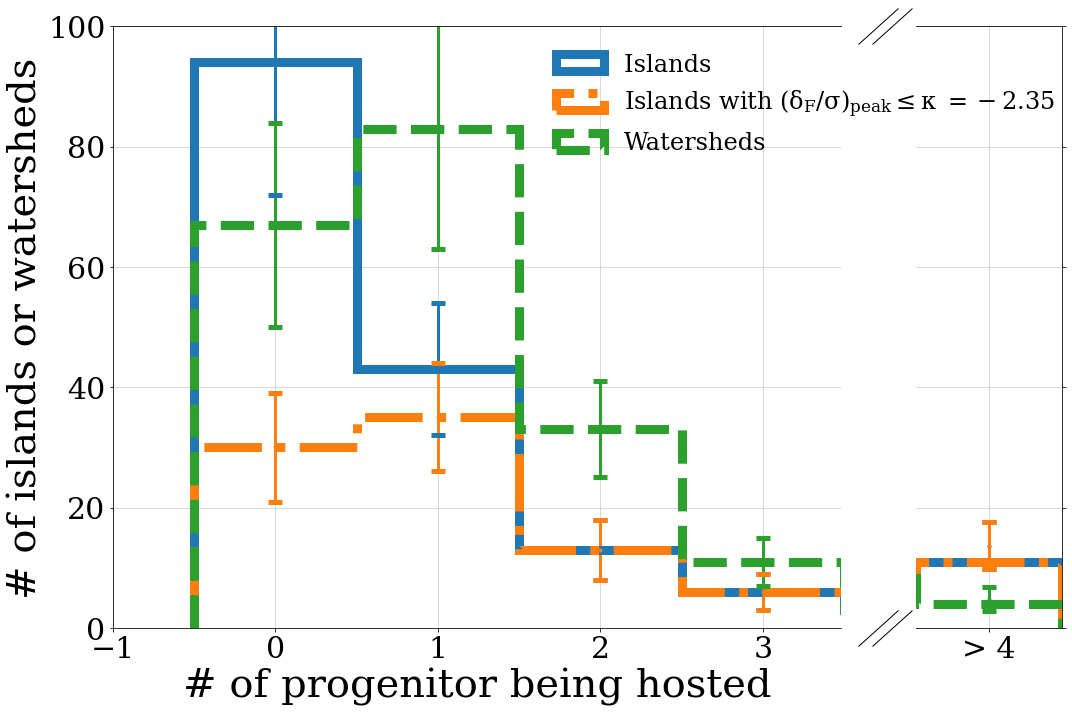

In [6]:
plot_prog_count_for_paper(savefig='islands_subregions_progs_count_mock.pdf', density=False)

## Completeness (Figure 11) :

In [6]:
def get_mean_std_hmf(nmocks=20):
    
    all_GMass = 10+np.log10(h5py.File('./halos/all_halos_z0.hdf5', 'r')['GroupMass'][:])
    bins = np.arange(12,16.5, 0.3)
    mbin = np.array([(bins[i+1]+bins[i])/2 for i in range(bins.size - 1)])
    ind = np.where(all_GMass > 13.5)
    hist_all, _ = np.histogram(all_GMass[ind], bins, density=False )
    
    all_clusters = h5py.File('clusters_TNG300-1.hdf5','r')
    # Select only massive progenitors
    Mass = np.log10(all_clusters['Mass'][:])+10
    prog = np.zeros((205,205,205), dtype=int)
    fcofm = h5py.File('cofm_progenitors.hdf5','r')
    x, y, z = fcofm['x'][:].astype(int), fcofm['y'][:].astype(int), fcofm['z'][:].astype(int)
    # Count progenitors from 1 not 0
    prog[x,y,z] = fcofm['cluster_ind'][:]+1
    
    counts_all_mock, counts_all_true = np.empty((nmocks,mbin.size)), np.empty((nmocks,mbin.size))
    for i,n in enumerate(np.arange(1,nmocks+1)):
        lmap_mock = h5py.File('./thresh/n'+str(n)+'/labeled_map_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5','r')['map'][:]
        lmap_true = h5py.File('./thresh/n'+str(n)+'/labeled_map_TNG_true_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5','r')['map'][:]
        
        lmap_mock[np.where(lmap_mock)] = 1
        Mass_detected = Mass[prog[np.where(prog*lmap_mock)] - 1]
        counts, _ = np.histogram(Mass_detected, bins=bins, density=False)
        counts_all_mock[i,:] = counts
        
        lmap_true[np.where(lmap_true)] = 1
        Mass_detected = Mass[prog[np.where(prog*lmap_true)] - 1]
        counts, _ = np.histogram(Mass_detected, bins=bins, density=False)
        counts_all_true[i,:] = counts
    print(np.all(counts_all_mock[0,:]==counts_all_mock[5,:]))
    return hist_all, np.median(counts_all_true, axis=0), np.median(counts_all_mock, axis=0), np.std(counts_all_true, axis=0), np.std(counts_all_mock, axis=0), mbin, bins
        
        
def mass_func():
    fig, ax = plt.subplots(1,2, figsize=(19,9))
    plt.style.use('Notebook.mystyle')
    #plt.style.use('Notebook.mystyle')
    call, ctrue, cmock, stdtrue, stdmock, mbin, bins = get_mean_std_hmf()

    
    ax[1].plot(mbin, np.ones_like(mbin), ls='-.', color='C3', lw=9, alpha=0.7)
    
    
    ax[0].hist(np.repeat(mbin, call.astype(int)), histtype='step', label='HMF', bins=bins, ls='-.', color='C2', lw=9, alpha=0.7)
    ax[0].hist(np.repeat(mbin,cmock.astype(int)), histtype='step', label='Mock', bins=bins, ls='solid', color='C0', lw=9, alpha=0.7)
    ax[0].errorbar(mbin, cmock, yerr=np.around(stdmock), color='C0', lw=9, alpha=0.7, fmt='.', capsize=5)
    ax[0].hist(np.repeat(mbin,ctrue.astype(int)), histtype='step', label='Noiseless', bins=bins, ls='dashed', color='C1', lw=9, alpha=0.7)
    ax[1].plot(mbin, cmock/call, label='Mock', ls='solid', color='C0', lw=9, alpha=0.7)
    ax[1].plot(mbin, ctrue/call, label='Noiseless', ls='dashed', color='C1', lw=9, alpha=0.7)

    ax[1].plot([14.125, 14.375, 14.625, 15], [0.05, 0.2, 0.55, 0.75], lw=9, ls='dotted', marker='D', label='Stark et. al. 2015', color='C5')
    msun = r'$ \rm h^{-1} M_{\odot}$'
    
    ax[0].set_yscale('log')
    ax[0].legend()
    ax[0].set_xlabel('log ( FOF Group Mass (z=0 )  '+msun+' )')
    ax[0].set_ylabel('count')
    ax[0].set_ylim((0.7,1e3))
    ax[0].set_xlim((13.5,15.5))
    ax[1].set_xlim((13.5,15.5))
    ax[0].legend(framealpha=0.2, loc='upper right')
    ax[1].set_xlabel('log ( FOF Group Mass (z=0 )  '+msun+' )')
    ax[1].set_ylabel('Completeness')
    ax[1].set_yticks(np.arange(0,1.1,0.1))
    ax[1].grid('True', alpha=0.9)
    ax[1].legend(framealpha=0.8, loc=(0.46,0.02))
    fig.tight_layout()
    fig.savefig('HMF.pdf')
    
    

#mass_func()
#plt.savefig('HMF.png', dpi=300)
#


In [27]:
get_mean_std_hmf()

False


(array([  0,   0,   0,   0,   0, 623, 286, 125,  51,   9,   2,   0,   0,
          0]),
 array([  0.,   0.,   0.,   0.,   0., 102.,  88.,  80.,  46.,   8.,   2.,
          0.,   0.,   0.]),
 array([ 0. ,  0. ,  0. ,  0. ,  0. , 75. , 58. , 44.5, 31. ,  7.5,  2. ,
         0. ,  0. ,  0. ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        7.18401002, 5.71401785, 4.68268086, 3.05777697, 0.84261498,
        0.21794495, 0.        , 0.        , 0.        ]),
 array([12.15, 12.45, 12.75, 13.05, 13.35, 13.65, 13.95, 14.25, 14.55,
        14.85, 15.15, 15.45, 15.75, 16.05]),
 array([12. , 12.3, 12.6, 12.9, 13.2, 13.5, 13.8, 14.1, 14.4, 14.7, 15. ,
        15.3, 15.6, 15.9, 16.2]))

False


<ipython-input-6-dd2ed5d3e262>:50: RuntimeWarning: invalid value encountered in true_divide
  ax[1].plot(mbin, cmock/call, label='Mock', ls='solid', color='C0', lw=9, alpha=0.7)
<ipython-input-6-dd2ed5d3e262>:51: RuntimeWarning: invalid value encountered in true_divide
  ax[1].plot(mbin, ctrue/call, label='Noiseless', ls='dashed', color='C1', lw=9, alpha=0.7)


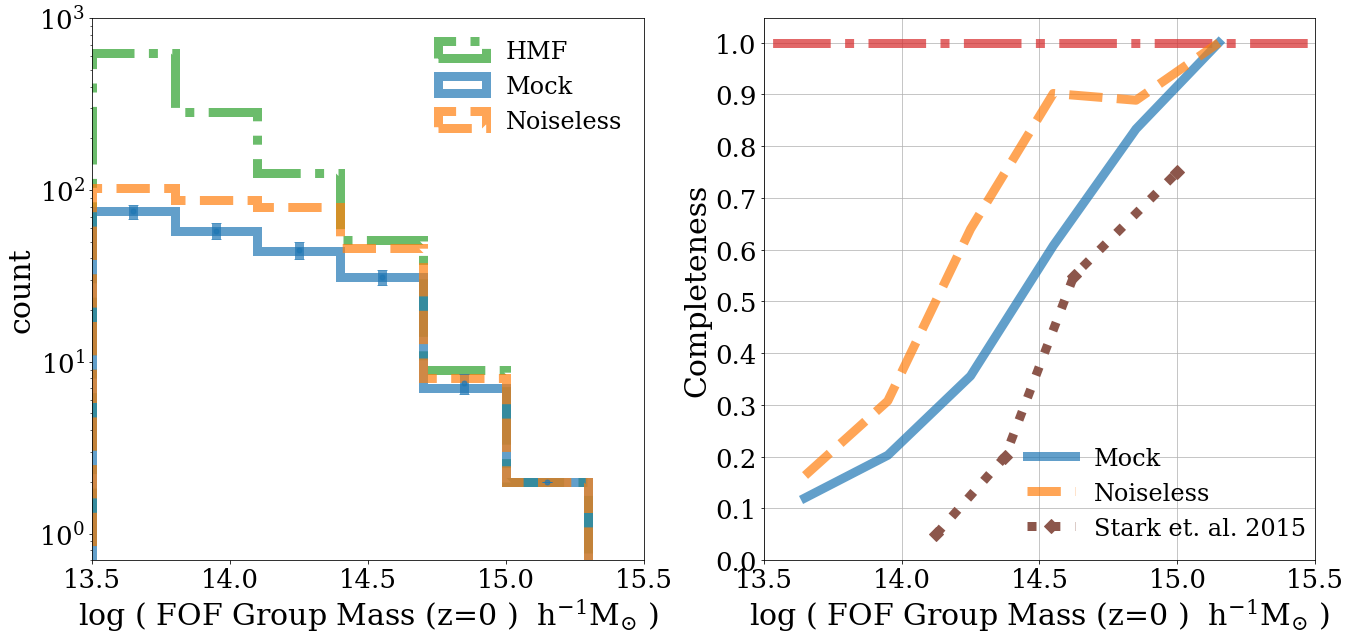

In [7]:
mass_func()